IMPORTING NECESSARY LIBRARIES

In [25]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

LOADING THE DATASET

In [28]:
data_path = 'D:/down/tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set dataa'

LAODING AND PREPROCESSING DATASET

In [35]:
def load_emotional_speech_dataset():
    paths = []
    labels = []

    dataset_dir = 'D:/down/tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/'

    for root, _, filenames in os.walk(dataset_dir):
        for filename in filenames:
            paths.append(os.path.join(root, filename))
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())

    print('Speech Emotion Dataset was Loaded')

    return paths, labels

# Call the function to load the dataset
dataset_paths, dataset_labels = load_emotional_speech_dataset()


Speech Emotion Dataset was Loaded


 Feature extraction and preprocessing

In [41]:
def extract_features(dataset_paths):
    features = []
    for path in dataset_paths:
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=1)
        features.append(mfccs)
    return np.array(features)

Encode the labels

In [42]:
label_encoder = LabelEncoder()
dataset_labels_encoded = label_encoder.fit_transform(dataset_labels)

EDA: Visualize the class distribution

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd 
from IPython.display import Audio
from pydub import AudioSegment

C:\Users\Have a Nice Day\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


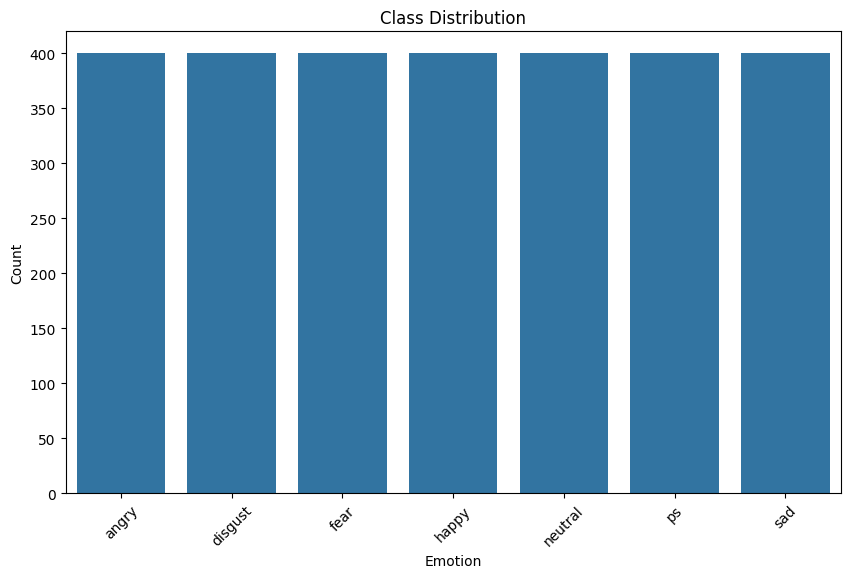

In [68]:
class_counts = pd.Series(dataset_labels).value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [69]:
data_frame = pd.DataFrame()
data_frame['speech'] = dataset_paths
data_frame['label'] = dataset_labels
data_frame.head()

,speech,label
0,D:/down/tess/TESS Toronto emotional speech set...,angry
1,D:/down/tess/TESS Toronto emotional speech set...,angry
2,D:/down/tess/TESS Toronto emotional speech set...,angry
3,D:/down/tess/TESS Toronto emotional speech set...,angry
4,D:/down/tess/TESS Toronto emotional speech set...,angry


In [70]:
def funcWaveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

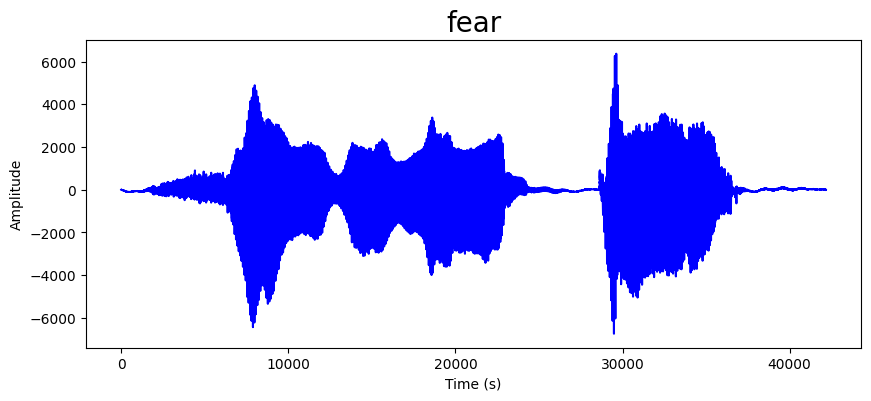

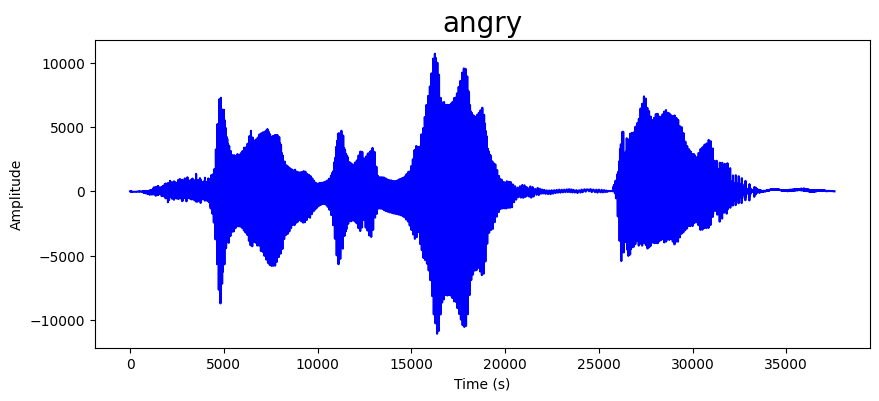

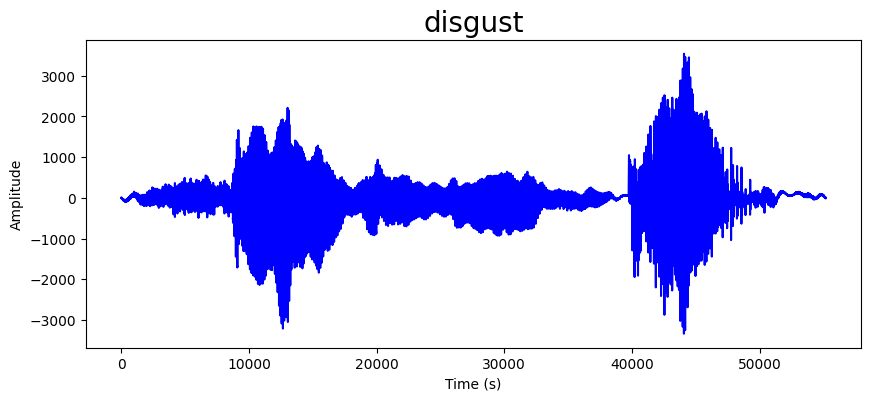

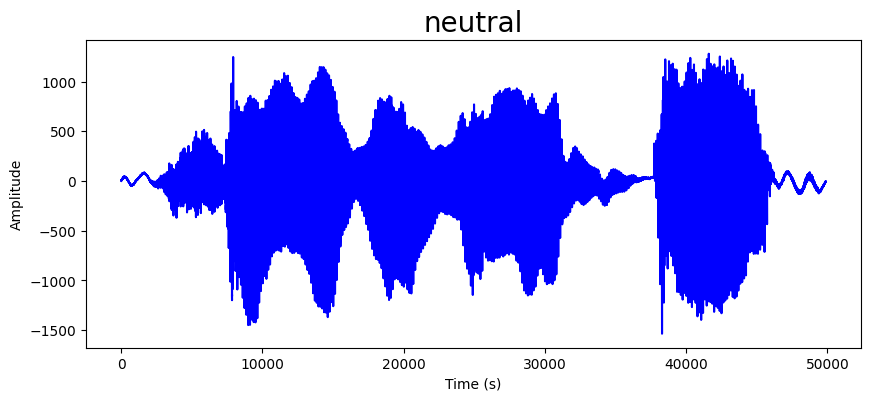

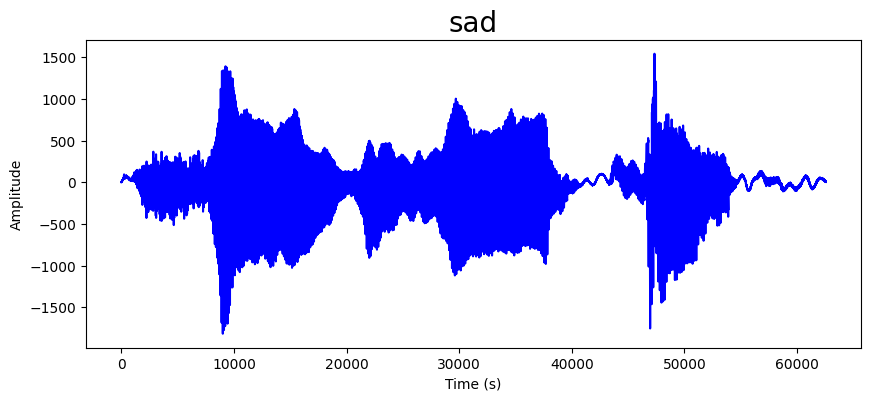

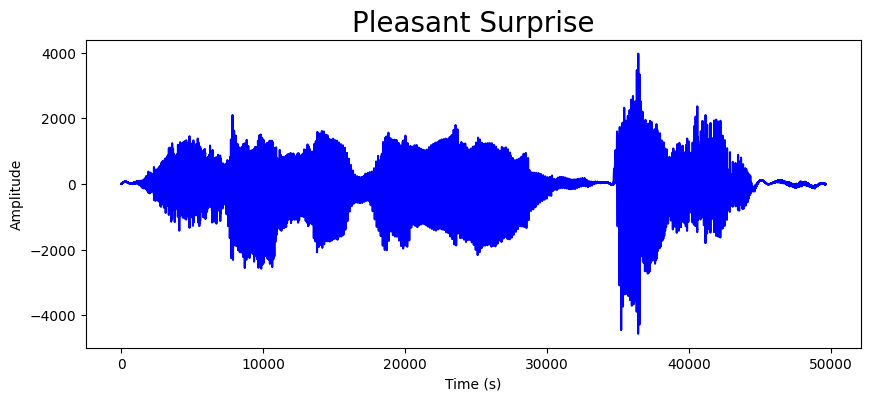

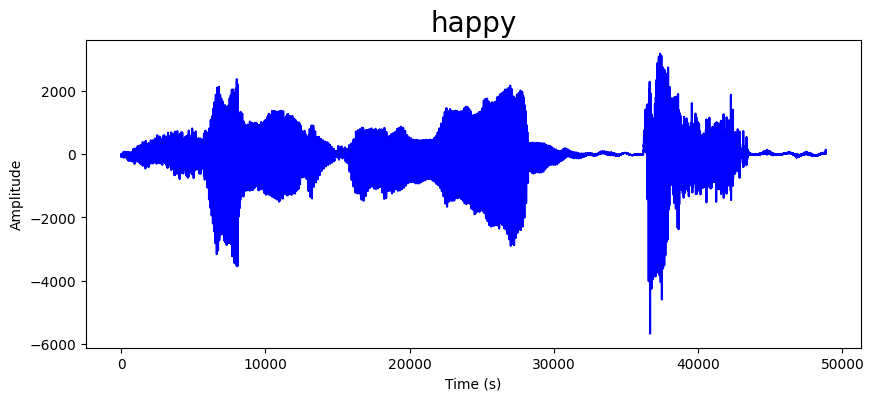

In [74]:
for emotion in emotions_to_plot:
    if emotion in dataset_labels:
        path = dataset_paths[dataset_labels.index(emotion)]
        data, sampling_rate = librosa.load(path)
        if emotion == 'ps':
            emotion = 'Pleasant Surprise'

        # Plot the audio waveform using pydub
        audio = AudioSegment.from_file(path)
        plt.figure(figsize=(10, 4))
        plt.title(emotion, size=20)
        plt.plot(audio.get_array_of_samples(), color='b')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

        # Play the audio
        ipd.Audio(path)
    else:
        print(f"No data found for emotion: {emotion}")

In [75]:
def extract_Mel_freq_cc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [76]:
x_Mel_freq_cc = data_frame['speech'].apply(lambda x: extract_Mel_freq_cc(x))

In [82]:
x = [x for x in x_Mel_freq_cc]
x = np.array(x)
x.shape
x = np.expand_dims(x, -1)
x.shape

(2800, 40, 1)

In [81]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(data_frame[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [83]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(123, return_sequences = False, input_shape=(40,1)),
    Dense(64, activation = 'relu'),
    Dropout(0.22),
    Dense(32, activation = 'relu'),
    Dropout(0.12),
    Dense(7, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics = ['accuracy'])
model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense (Dense)               (None, 64)                7936      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 71747 

In [84]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x,y, validation_split=0.2, epochs=20, batch_size=256, shuffle=True, callbacks=[early_stopping])

Epoch 1/20
9/9 [==============================] - 3s 153ms/step - loss: 1.8180 - accuracy: 0.3580 - val_loss: 2.0213 - val_accuracy: 0.1607
Epoch 2/20
9/9 [==============================] - 1s 97ms/step - loss: 1.4737 - accuracy: 0.4853 - val_loss: 2.4167 - val_accuracy: 0.2482
Epoch 3/20
9/9 [==============================] - 1s 93ms/step - loss: 1.1122 - accuracy: 0.5768 - val_loss: 2.6201 - val_accuracy: 0.2429
Epoch 4/20
9/9 [==============================] - 1s 100ms/step - loss: 0.8806 - accuracy: 0.6616 - val_loss: 2.2074 - val_accuracy: 0.4518
Epoch 5/20
9/9 [==============================] - 1s 90ms/step - loss: 0.6809 - accuracy: 0.7460 - val_loss: 2.0884 - val_accuracy: 0.5696
Epoch 6/20
9/9 [==============================] - 1s 87ms/step - loss: 0.5139 - accuracy: 0.8237 - val_loss: 1.8507 - val_accuracy: 0.5446
Epoch 7/20
9/9 [==============================] - 1s 86ms/step - loss: 0.3616 - accuracy: 0.8795 - val_loss: 1.8554 - val_accuracy: 0.3875
Epoch 8/20
9/9 [=========

FINAL ACCURACY OF THE MODEL

In [85]:
final_accuracy = history.history['accuracy'][-1]
print(f'Final Training Accuracy: {final_accuracy:.2%}')

Final Training Accuracy: 97.72%
